In [ ]:
import sys
sys.path.append("../birdgp")

import numpy as np
import matplotlib.pyplot as plt
import math
import bird_gp_uncertainty
import random
import torch

%matplotlib inline

In [ ]:
train_data = np.loadtxt("fashion-mnist_train.csv", skiprows = 1, delimiter = ",")
test_data = np.loadtxt("fashion-mnist_test.csv", skiprows = 1, delimiter = ",")

train_img = train_data[:, 1:]
test_img = test_data[:, 1:]
train_label = train_data[:, 0]
test_label = test_data[:, 0]
train_img = train_img / 255
test_img = test_img / 255

train_idx_all = np.arange(60000)
test_idx_all = np.arange(10000)

n = 2000
n_train = 1000
n_test = 1000

exp = 0

random.seed(exp)
torch.manual_seed(exp)
np.random.seed(exp)

#####################################################################
# generate images
train_idx = np.random.choice(train_idx_all, size = n_train, replace = False)
test_idx = np.random.choice(test_idx_all, size = n_test, replace = False)

train_imgs = train_img[train_idx, ]
test_imgs = test_img[test_idx, ]
train_lbs = train_label[train_idx]
test_lbs = test_label[test_idx]

train_quantiles = np.zeros((4, n_train))
for i in range(n_train):
    train_img_i = train_imgs[i, :]
    train_img_i = train_img_i[train_img_i > 0]
    train_quantiles[:, i] = np.quantile(train_img_i, [0, 0.25, 0.5, 0.75])

train_q0 = np.tile(train_quantiles[0, :].reshape((n_train, 1)), (1, 784))
train_q1 = np.tile(train_quantiles[1, :].reshape((n_train, 1)), (1, 784))
train_q2 = np.tile(train_quantiles[2, :].reshape((n_train, 1)), (1, 784))
train_q3 = np.tile(train_quantiles[3, :].reshape((n_train, 1)), (1, 784))

train_p0 = np.zeros((n_train, 784))
train_p1 = np.zeros((n_train, 784))
train_p2 = np.zeros((n_train, 784))
train_p3 = np.zeros((n_train, 784))

train_p3[train_imgs >= train_q3] = train_imgs[train_imgs >= train_q3]
train_p2[(train_imgs >= train_q2) & (train_imgs < train_q3)] = train_imgs[(train_imgs >= train_q2) & (train_imgs < train_q3)]
train_p1[(train_imgs >= train_q1) & (train_imgs < train_q2)] = train_imgs[(train_imgs >= train_q1) & (train_imgs < train_q2)]
train_p0[(train_imgs >= train_q0) & (train_imgs < train_q1)] = train_imgs[(train_imgs >= train_q0) & (train_imgs < train_q1)]

train_predictors = np.zeros((n_train, 28*28*4))
train_outcomes = train_imgs
for i in range(n_train):
    train_p0_i = train_p0[i, :].reshape((28, 28))
    train_p1_i = train_p1[i, :].reshape((28, 28))
    train_p2_i = train_p2[i, :].reshape((28, 28))
    train_p3_i = train_p3[i, :].reshape((28, 28))
    train_predictor_i = np.hstack((train_p0_i, train_p1_i, train_p2_i, train_p3_i))
    train_predictors[i, :] = train_predictor_i.reshape(-1)

test_quantiles = np.zeros((4, n_test))
for i in range(n_test):
    test_img_i = test_imgs[i, :]
    test_img_i = test_img_i[test_img_i > 0]
    test_quantiles[:, i] = np.quantile(test_img_i, [0, 0.25, 0.5, 0.75])


test_q0 = np.tile(test_quantiles[0, :].reshape((n_test, 1)), (1, 784))
test_q1 = np.tile(test_quantiles[1, :].reshape((n_test, 1)), (1, 784))
test_q2 = np.tile(test_quantiles[2, :].reshape((n_test, 1)), (1, 784))
test_q3 = np.tile(test_quantiles[3, :].reshape((n_test, 1)), (1, 784))

test_p0 = np.zeros((n_test, 784))
test_p1 = np.zeros((n_test, 784))
test_p2 = np.zeros((n_test, 784))
test_p3 = np.zeros((n_test, 784))

test_p3[test_imgs >= test_q3] = test_imgs[test_imgs >= test_q3]
test_p2[(test_imgs >= test_q2) & (test_imgs < test_q3)] = test_imgs[(test_imgs >= test_q2) & (test_imgs < test_q3)]
test_p1[(test_imgs >= test_q1) & (test_imgs < test_q2)] = test_imgs[(test_imgs >= test_q1) & (test_imgs < test_q2)]
test_p0[(test_imgs >= test_q0) & (test_imgs < test_q1)] = test_imgs[(test_imgs >= test_q0) & (test_imgs < test_q1)]

test_predictors = np.zeros((n_test, 28*28*4))
test_outcomes = test_imgs
for i in range(n_test):
    test_p0_i = test_p0[i, :].reshape((28, 28))
    test_p1_i = test_p1[i, :].reshape((28, 28))
    test_p2_i = test_p2[i, :].reshape((28, 28))
    test_p3_i = test_p3[i, :].reshape((28, 28))
    test_predictor_i = np.hstack((test_p0_i, test_p1_i, test_p2_i, test_p3_i))
    test_predictors[i, :] = test_predictor_i.reshape(-1)

fit basis for predictors ...


100%|██████████| 10000/10000 [09:09<00:00, 18.21it/s]


basis orthogonalization ...
fit basis for outcomes ...


100%|██████████| 10000/10000 [02:28<00:00, 67.54it/s]


basis orthogonalization ...
fit basis coefficients for predictors ...


100%|██████████| 1000/1000 [07:17<00:00,  2.28it/s]


fit basis coefficients for outcomes ...


100%|██████████| 1000/1000 [07:08<00:00,  2.33it/s]


stein variation gradient descent ...
epoch: 1 / 700, training rmse: 1.638, training r2: 0.097
epoch: 2 / 700, training rmse: 1.5536, training r2: 0.1877
epoch: 3 / 700, training rmse: 1.4749, training r2: 0.2678
epoch: 4 / 700, training rmse: 1.401, training r2: 0.3394
epoch: 5 / 700, training rmse: 1.3328, training r2: 0.4021
epoch: 6 / 700, training rmse: 1.2697, training r2: 0.4574
epoch: 7 / 700, training rmse: 1.2114, training r2: 0.5061
epoch: 8 / 700, training rmse: 1.1578, training r2: 0.5489
epoch: 9 / 700, training rmse: 1.109, training r2: 0.5861
epoch: 10 / 700, training rmse: 1.0645, training r2: 0.6186
epoch: 11 / 700, training rmse: 1.0253, training r2: 0.6462
epoch: 12 / 700, training rmse: 0.9889, training r2: 0.6709
epoch: 13 / 700, training rmse: 0.9569, training r2: 0.6918
epoch: 14 / 700, training rmse: 0.928, training r2: 0.7101
epoch: 15 / 700, training rmse: 0.903, training r2: 0.7256
epoch: 16 / 700, training rmse: 0.8801, training r2: 0.7393
epoch: 17 / 700, t

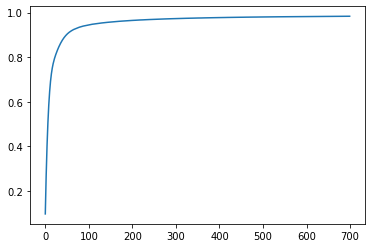

In [ ]:
predictor_grids = bird_gp_uncertainty.generate_grids([28, 112])
outcome_grids = bird_gp_uncertainty.generate_grids([28, 28])

birdgp = bird_gp_uncertainty.BIRD_GP(predictor_grids = predictor_grids,
                                     outcome_grids = outcome_grids,
                                     predictor_L = 50,
                                     outcome_L = 50,
                                     svgd_a_lambda = 0.01,
                                     svgd_b_lambda = 0.01,
                                     bf_predictor_steps = 10000,
                                     bf_outcome_steps = 10000,
                                     svgd_num_particles = 20,
                                     svgd_epochs = 700
                                     )
birdgp.fit(train_predictors, train_outcomes)

In [ ]:
train_pred, train_coverage_rate = birdgp.predict_train(sample = True, size = 500, CI = 0.95)

sampling training images


100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


In [ ]:
test_pred, test_coverage_rate = birdgp.predict_test(test_predictors, sample = True, size = 500, test_outcomes = test_outcomes)

100%|██████████| 1000/1000 [07:33<00:00,  2.20it/s]


sampling testing images


100%|██████████| 1000/1000 [01:48<00:00,  9.21it/s]


In [ ]:
np.quantile(train_coverage_rate, 0.025), np.quantile(train_coverage_rate, 0.975)

(0.9540816326530612, 0.9948979591836735)

In [ ]:
np.quantile(test_coverage_rate, 0.025), np.quantile(test_coverage_rate, 0.975)

(0.8762436224489797, 0.9961734693877551)

In [ ]:
np.std(train_coverage_rate)

0.010767571577084521

In [ ]:
np.std(test_coverage_rate)

0.03181902173969297

In [ ]:
np.savetxt("train_coverage_rate.txt", train_coverage_rate)
np.savetxt("test_coverage_rate.txt", test_coverage_rate)

In [ ]:
np.mean(train_coverage_rate), np.mean(test_coverage_rate)

(0.9766530612244898, 0.9585943877551021)

In [ ]:
np.mean((train_pred - train_outcomes)**2), np.mean((test_pred - test_outcomes)**2)

(0.016514566396214007, 0.02231107887794728)